# Notebook for performance testing of K-banded and adaptive-K strategies

In [17]:
import allel
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import sys
sys.path.append('../../src/')
from gen_ld_mat import *
from perf import *
from utils import *

#### Function to convert any matrix to lower triangular

In [2]:
def lowertri(x):
    for i in range(len(x)):
        for j in range(len(x[i])):
            if i<=j:
                x[i][j]=0
    return x

### Reading in genotype matrix

In [3]:
vcf_path = '/project2/jnovembre/data/external_public/geo_LD/ALL.chr22.phase3_shapeit2_mvncall_integrated.20130502.biallelic_snps.ac5.genotypes.vcf.gz'
popfile = '/project2/jnovembre/data/external_public/1kg_phase3/haps/integrated_call_samples_v3.20130502.ALL.panel'

In [4]:
callset = allel.read_vcf(vcf_path,region='22:20000000-25000000', fields=['calldata/GT','samples','variants/POS'])

In [5]:
gt = allel.GenotypeArray(callset['calldata/GT'])

In [7]:
# Filtering to CEU indivs only

panel = pd.read_csv(popfile, sep='\t', usecols=['sample', 'pop', 'super_pop'])
pop_check = (panel['pop']=='CEU')
pop_indices = panel[pop_check].index.values
pop_gt = gt.take(pop_indices,axis=1)

In [8]:
a = pop_gt.to_n_alt()

idx1 = ~np.all(a==0, axis=1)
idx2 = ~np.all(a==1, axis=1)
idx3 = ~np.all(a==2, axis=1)

# Filtering to only segregating variants

a = a[idx1 & idx2 & idx3]

### Comparison plot

In [23]:
# Creating P x P matrix from K x P file

K100_file = '../../data/performance_tests/chr22_ac5_K100_pos20000000_25000000_popCEU.npz'

k_banded = kxp_file_convert(K100_file)

100%|██████████| 19855/19855 [00:00<00:00, 209565.85it/s]


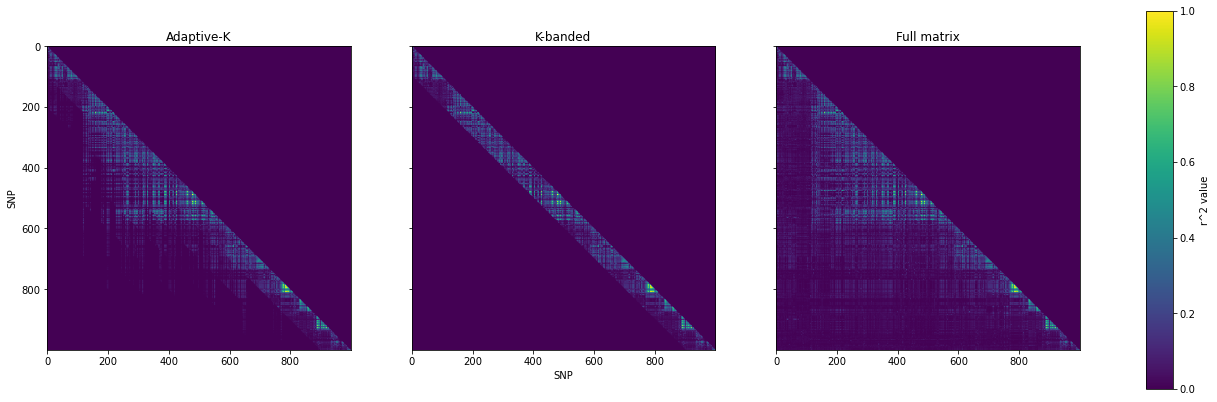

In [24]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,sharey=True,sharex=True)

im1 = ax1.imshow(arm[:1000,:1000])
ax2.imshow(k_banded[:1000,:1000])
ax3.imshow(lowertri(gen_mat_LD))

ax1.set_title('Adaptive-K')
ax2.set_title('K-banded')
ax3.set_title('Full matrix')

ax1.set_ylabel('SNP')
ax2.set_xlabel('SNP')

cb_ax = fig.add_axes([0.95, 0.25, 0.02, 0.5])
cbar1 = plt.colorbar(im1, cax = cb_ax)
cbar1.ax.set_ylabel('r^2 value', rotation=90)

fig.set_size_inches(18.5, 10.5)

#plt.savefig('matrix_method_comparison.png',dpi=300)

### Creating plot to depict potentially useful LD sums

Text(0.5, 1.0, 'Sample LD matrix')

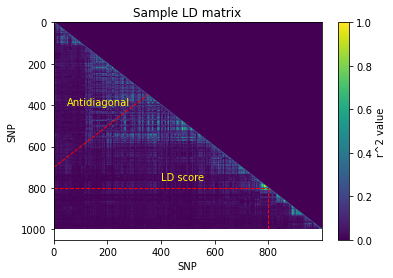

In [25]:
gen_mat_sample = (a[:1000,:])
gen_mat_LD = np.tril(np.corrcoef(gen_mat_sample)**2)

import matplotlib.pyplot as plt

im1 = plt.imshow(gen_mat_LD, aspect='auto')
plt.plot([0, 350], [700, 350],color='red', linestyle='--', linewidth=1)
plt.plot([0, 800], [800, 800],color='red', linestyle='--', linewidth=1)
plt.plot([800, 800], [800, 1000],color='red', linestyle='--', linewidth=1)
plt.text(50,400,'Antidiagonal',color='yellow')
plt.text(400,760,'LD score',color='yellow')

plt.xlabel("SNP")
plt.ylabel("SNP")

cbar1 = plt.colorbar(im1)

cbar1.ax.set_ylabel('r^2 value', rotation=90)

plt.title("Sample LD matrix")

#plt.savefig('LD_sample_plot.png',dpi=300)

### Performance testing K x P matrices 

In [26]:
CEU_full = '../../data/ld_mats_perf/chr22_ac5_full_LD_pos20000000_25000000_popCEU.npz'
CHB_full = '../../data/ld_mats_perf/chr22_ac5_full_LD_pos20000000_25000000_popCHB.npz'
FIN_full = '../../data/ld_mats_perf/chr22_ac5_full_LD_pos20000000_25000000_popFIN.npz'
kxp_mat_files_CEU =[]
kxp_mat_files_CHB =[]
kxp_mat_files_FIN =[]

for name in glob.glob('/project2/jnovembre/achyutha11/geo_LD_viz_v2/data/performance_tests/*0_pos20000000_25000000_popCEU.npz'):
    kxp_mat_files_CEU.append(str(name))
    
for name in glob.glob('/project2/jnovembre/achyutha11/geo_LD_viz_v2/data/performance_tests/*0_pos20000000_25000000_popCHB.npz'):
    kxp_mat_files_CHB.append(str(name))
    
for name in glob.glob('/project2/jnovembre/achyutha11/geo_LD_viz_v2/data/performance_tests/*0_pos20000000_25000000_popFIN.npz'):
    kxp_mat_files_FIN.append(str(name))

# Make sure order of list is correct

In [ ]:
CEU_perf_test_01 = frac_covered_k_banded_all(CEU_full,kxp_mat_files_CEU,0.1)
CHB_perf_test_01 = frac_covered_k_banded_all(CHB_full,kxp_mat_files_CHB,0.1)
FIN_perf_test_01 = frac_covered_k_banded_all(FIN_full,kxp_mat_files_FIN,0.1)

CEU_perf_test_025 = frac_covered_k_banded_all(CEU_full,kxp_mat_files_CEU,0.25)
CHB_perf_test_025 = frac_covered_k_banded_all(CHB_full,kxp_mat_files_CHB,0.25)
FIN_perf_test_025 = frac_covered_k_banded_all(FIN_full,kxp_mat_files_FIN,0.25)

CEU_perf_test_05 = frac_covered_k_banded_all(CEU_full,kxp_mat_files_CEU,0.5)
CHB_perf_test_05 = frac_covered_k_banded_all(CHB_full,kxp_mat_files_CHB,0.5)
FIN_perf_test_05 = frac_covered_k_banded_all(FIN_full,kxp_mat_files_FIN,0.5)

CEU_perf_test_08 = frac_covered_k_banded_all(CEU_full,kxp_mat_files_CEU,0.8)
CHB_perf_test_08 = frac_covered_k_banded_all(CHB_full,kxp_mat_files_CHB,0.8)
FIN_perf_test_08 = frac_covered_k_banded_all(FIN_full,kxp_mat_files_FIN,0.8)

In [20]:
def swapPositions(list, pos1, pos2): 
    list[pos1], list[pos2] = list[pos2], list[pos1] 
    return list

In [ ]:
x = [1,1,1,1,1]
K = [100,200,500,1000,2500]

plt.plot(FIN_perf_test_01[0],FIN_perf_test_01[1],label=0.1)
plt.plot(FIN_perf_test_025[0],FIN_perf_test_025[1],label=0.25)
plt.plot(FIN_perf_test_05[0],FIN_perf_test_05[1],label=0.5)
plt.plot(FIN_perf_test_08[0],FIN_perf_test_08[1],label=0.8)
plt.plot(K,x,linestyle='--')

plt.xlabel('K')
plt.ylabel('Fraction of LD detected above epsilon')
plt.title('Performance tests: K-banded LD matrix on chr22, FIN')
plt.legend(title='Epsilon values')

#plt.savefig('FIN_kxp_performance_test.png',dpi=300)

In [15]:
filepath = '/project2/jnovembre/achyutha11/geo_LD_viz_v2/data/performance_tests/adaptive_chr22_ac5_pos20000000_25000000_popCEU.npz'

In [18]:
adaptive_file_convert(filepath,100)

ValueError: Object arrays cannot be loaded when allow_pickle=False